# Todo

-1. Add XGBOOST
0. Do multiple runs with random sampling. Make sure the adaboost I use actually has convergence proof on minimal maximal margin. 
1. Use more datasets. The following were used in the XGBoost article. 
    - HIGGS
    - Yahoo!
    - Allstate  

2. Figure out if it is possible to alter weights in the XGBoost python implementation. This didn't seem to be the case. Sent a mail to them. 

3. Finish lowerbound.

4. Use Kaspers Java/c++ instead of random sampling.

5. Write article.

6. Check out applications for GAN's, see 
    - https://www.youtube.com/watch?v=9VtPt33MKK0&feature=youtu.be
    - https://arxiv.org/abs/1701.02386
    - https://github.com/tolstikhin/adagan

7. Maximal Minimal Margin score. 

See the following links for AdaBoostClassifier and DecisionTreeClassifier documentation:

    http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
    http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

To do real experiments I need more computing power. The cheapest (and easiest way) is to use Amazon server park. 


# Optimal Boosting for Maximizing Minimal Margin
A weak base classifier is any classifier that achieves error $..$. Boosting algorithms combine several weak base classifiers into a strong classifier. A strong classifier is ... exp guarantee. This was first proved in the AdaBoost paper [..], a nice explanation can be found in the []. 

Later results proved a relation between maximizing minimal margin and generalization. (give more details). Several boosting algorithms provably bound the gap between the obtained maximial margin and the optimal maximal margin by $O(\frac{\log n}{\epsilon^2})$. Equivalently, after $t$ iterations/hypothesis, the obtained maximal minimal marign is $\epsilon=O(..)$ from the optimal. It was conjectured by [<a href="https://users.soe.ucsc.edu/~manfred/pubs/open/P10.pdf" target="_new">1</a>] that this was optimal. 

In other words, for their conjecture to be true, there must exist no algorithm that finds $t$ hypothesis such that the gap between the optimal and miimal margin is $O(..)$. 

Explain Game Theory formulation of boosting. 

$$ gap(U)_t:= val(U)-\text{max}_{U_t} val(U_t) = O\left(\sqrt{\frac{\log n}{t}}\right) $$

where for convex $d, w$

$$val(U_t) = \text{min}_{d}\text{max}_{w} d^T U_t w=\text{max}_{ w}\text{min} [U_tw]_r$$

This is proven false by us in [?]. Our proof is constructive and yields an algorithm. The idea of the algorithm is to produce too many hypothesis, then select a combination of $t$ hypothesis from these such that the gap $U_t=O(\sqrt{ \frac{ \log{\frac{n}{t}}}{n} } )$ improving on the previous $O(\sqrt{..})$ algorithms!  

In our proof we use Spencers lemma that states 

$$\forall A\in[-1, +1]^{n \times m}: \quad \exists x\in\{-1, +1\}^t: \quad ||Ax||_\infty \le c \sqrt{m \log \frac{n}{m}}$$

In our algorithm we thus face the following subproblem: given matrix $A$ find vector $x$ such that 

$$ ||Ax||_\infty \le c\sqrt{m \log \frac{n}{m}} $$

which is NP-C [.]. In this notebook we investigate heuristically approximating this in different ways for different algorithms

[1] https://users.soe.ucsc.edu/~manfred/pubs/open/P10.pdf

[2] http://www.jmlr.org/papers/volume6/ratsch05a/ratsch05a.pdf

they write $\rho^* - v$ margin in $2\frac{\log n}{v^2}$ iterations. 

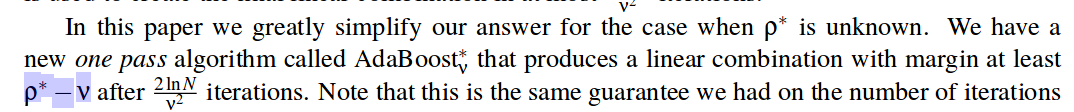

[3] https://link.springer.com/content/pdf/10.1007/978-3-540-87987-9_23.pdf

## Import Data
We will use the AirLine dataset as prepared by [2] which some of our code base derives from; thanks. 

Use multiple datasets; take all the one's from the gradient boosting article, make a class that contains them all. 

https://arxiv.org/pdf/1603.02754.pdf


asd


In [1]:
import time
import numpy as np
import pandas as pd

t0 = time.time()
print("Loading data...\t", end='')
d_train = pd.read_csv("data/train-0.1m.csv")
d_test = pd.read_csv("data/test.csv")
d_train_test = d_train.append(d_test)
print("DONE!", round(time.time()-t0, 4), "s")

vars_cat = ["Month","DayofMonth","DayOfWeek","UniqueCarrier", "Origin", "Dest"]
vars_num = ["DepTime","Distance"]
def my_get_dummies(d, col):
    dd = pd.get_dummies(d.ix[:, col])
    dd.columns = [col + "_%s" % c for c in dd.columns]
    return(dd)

t1 = time.time()
print("Manage data...\t", end='')
X_train_test_cat = pd.concat([my_get_dummies(d_train_test, col) for col in vars_cat], axis = 1)

X_train_test = pd.concat([X_train_test_cat, d_train_test.ix[:,vars_num]], axis = 1)
y_train_test = np.where(d_train_test["dep_delayed_15min"]=="Y", 1, 0)

X_train = X_train_test[0:d_train.shape[0]]
y_train = y_train_test[0:d_train.shape[0]]
X_test = X_train_test[d_train.shape[0]:]
y_test = y_train_test[d_train.shape[0]:]

print("DONE!", round(time.time()-t1, 4), "s")
print("Train Shape: \t", X_train.shape, y_train.shape)

Loading data...	DONE! 0.214 s
Manage data...	

/home/ubudevml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app


DONE! 2.0371 s
Train Shape: 	 (100000, 689) (100000,)


Let us start by building a simple AdaBoost classifier using Decision Trees as base classifier. 

In [2]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=10)
ada.fit(X_train[:10000], y_train[:10000])

pred = ada.predict(X_train[:10000])
#1-0 in-sample loss
print(np.sum(np.abs(pred - y_train[:10000]))/10000)

# 
print(1-ada.score(X_train[:10000], y_train[:10000]))

0.1863
0.1863


In the following we define functions that train both models, and train both subject to some time constraint to get a baseline to compare our results against. 


<IPython.core.display.Javascript object>


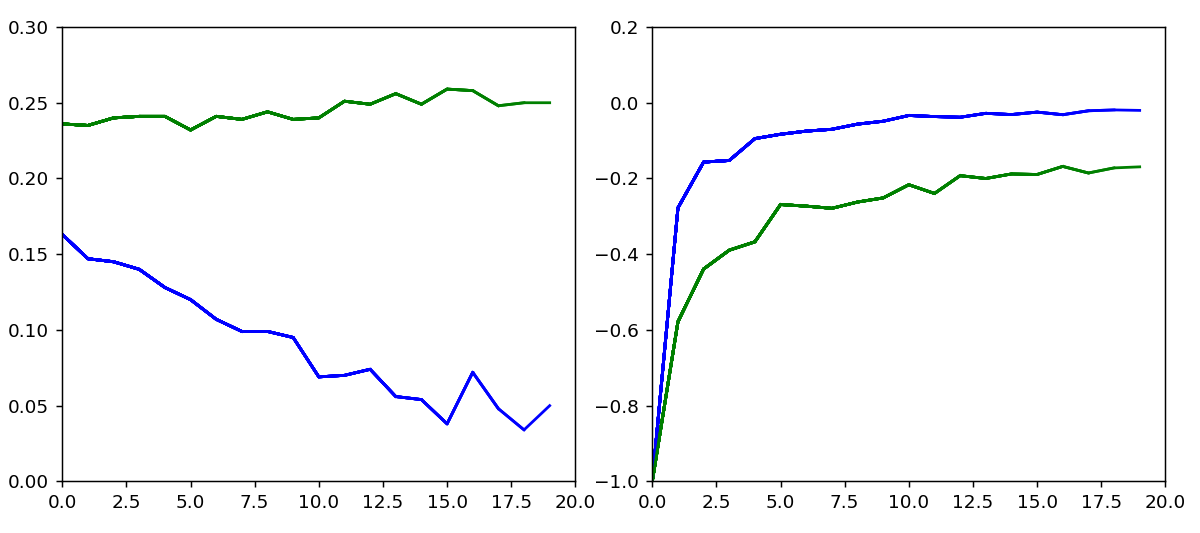

Name	 E_in	 E_test	 mm_in	 mm_test time	 data_size
Ada1 	 0.163 	 0.236 	 -1.0 	 -1.0 	 0.03 	 1000
Ada51 	 0.147 	 0.235 	 -0.2778 	 -0.5785 	 0.477 	 1000
Ada101 	 0.145 	 0.24 	 -0.1567 	 -0.4392 	 0.903 	 1000
Ada151 	 0.14 	 0.241 	 -0.1525 	 -0.3895 	 1.399 	 1000
Ada201 	 0.128 	 0.241 	 -0.0948 	 -0.3673 	 1.691 	 1000
Ada251 	 0.12 	 0.232 	 -0.0832 	 -0.2688 	 2.077 	 1000
Ada301 	 0.107 	 0.241 	 -0.075 	 -0.2731 	 2.532 	 1000
Ada351 	 0.099 	 0.239 	 -0.0701 	 -0.2789 	 2.912 	 1000
Ada401 	 0.099 	 0.244 	 -0.0565 	 -0.2623 	 3.657 	 1000
Ada451 	 0.095 	 0.239 	 -0.0489 	 -0.2514 	 4.042 	 1000
Ada501 	 0.069 	 0.24 	 -0.0337 	 -0.2166 	 4.966 	 1000
Ada551 	 0.07 	 0.251 	 -0.0365 	 -0.2397 	 5.567 	 1000
Ada601 	 0.074 	 0.249 	 -0.0384 	 -0.1926 	 6.826 	 1000
Ada651 	 0.056 	 0.256 	 -0.028 	 -0.2001 	 6.778 	 1000
Ada701 	 0.054 	 0.249 	 -0.0312 	 -0.1881 	 7.763 	 1000
Ada751 	 0.038 	 0.259 	 -0.0248 	 -0.1895 	 8.095 	 1000
Ada801 	 0.072 	 0.258 	 -0.0316 	 -0.

In [33]:
# Interactive Plotting
%matplotlib notebook 
import matplotlib.pyplot as plt

# compute 0-1 and min marginal score on train and test datasets. 
def test(classifier, test_size): 
    
    E_in   = 1 - classifier.score(X_train[:test_size], y_train[:test_size])
    E_test = 1 - classifier.score(X_test[:test_size],  y_test[:test_size])
    
    est = classifier.estimators_
    weights = classifier.estimator_weights_ / np.sum(classifier.estimator_weights_)
    T = classifier.n_estimators
 
    # *2-1 converts from binary to {-1, 1} classification
    # maybe do this in a more efficient manner? Take approximately one second to compute both.
    t = time.time()
    
    # TODO: Calling sklearn.decision_function is 10 x faster than if I run source code in here!
    '''
    t = time.time()
    H_train = np.sum([(est[i].predict(X_train[:test_size])*2-1)*weights[i] for i in range(T)], axis=0)
    margins_train = H_train*(y_train[:test_size]*2-1)
    print("In here: ", time.time()-t)
    t = time.time()
    '''
    
    H_train       = classifier.decision_function(X_train[:test_size])
    margins_train = H_train * (y_train[:test_size]*2-1)
    
    H_test        = classifier.decision_function(X_test[:test_size])
    margins_test  = H_test * (y_test[:test_size]*2-1)    
    
    return round(E_in, 3), round(E_test, 3), margins_train, margins_test

def ABoost(n, t):
    t0 = time.time()

    # we want the DecisionTree to be able to do at least something => 
    # don't have max_depth = 1. (the leaves will be exponentielt in depth!!!)
    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=t, algorithm="SAMME")
    ada.fit(X_train[:n], y_train[:n])
    
    E_in, E_test, margin_train, margin_test = test(ada, n_test)

    return ada, n, E_in, E_test, margin_train, margin_test, round(time.time() - t0, 3)

def header(): # mm: minimal margin
    print("Name\t", "E_in\t", "E_test\t", "mm_in\t", "mm_test", "time\t", "data_size")


def p(name, result): 
    alg, n, E_in, E_test, margin_in, margin_test, t = result 
    min_margin_in = np.min(margin_in)
    min_margin_test = np.min(margin_test)
    
    E_in_vals.append(E_in)
    E_test_vals.append(E_test)
    margin_in_vals.append(min_margin_in)
    margin_test_vals.append(min_margin_test)
    
    print(name, "\t", E_in, "\t", E_test,  "\t", round(min_margin_in, 4),  "\t", round(min_margin_test, 4),  "\t",t, "\t", n)
    
n_test = 1000
train_steps = 1000
step_size = 50

#visualiation
fig, (ax_error, ax_margin) = plt.subplots(1, 2, figsize=(9,4)) 
fig.tight_layout()

ax_error.set_xlim(0, train_steps/step_size)
ax_error.set_ylim(0, 0.3)
ax_margin.set_xlim(0, train_steps/step_size)
ax_margin.set_ylim(-1, 0.2)

E_in_vals = []
E_test_vals = []
margin_in_vals = []
margin_test_vals = []

header()

for i in range(1, train_steps, step_size):
    p("Ada" + str(i), ABoost(1000, i))
    
    ax_error.plot(E_in_vals, color='b')
    ax_error.plot(E_test_vals, color='g')

    ax_margin.plot(margin_in_vals, color='b')
    ax_margin.plot(margin_test_vals, color='g')

    fig.canvas.draw()  

# AdaBoost: Random Sample
https://stackoverflow.com/questions/31981453/why-estimator-weight-in-samme-r-adaboost-algorithm-is-set-to-1


In [34]:
%matplotlib notebook
import copy

# ideas
def simplify_ada(ada, target):
    t0 = time.time()
    
    # sample 'target' hypothesis
    count = ada.n_estimators
    probs = ada.estimator_weights_ / np.sum(ada.estimator_weights_)
    
    indx = np.random.choice(count, target, replace=False, p=probs)
    new_weights = np.zeros(len(probs))
    for i in indx: new_weights[i] += 1
    ada.estimator_weights_ = new_weights / target
    E_in, E_test, margins_train, margins_test = test(ada, n_test)
    #ra_in, ra_test = test_roc_auc(ada, n_test)
    return ada, n, E_in, E_test, margins_train, margins_test, round(time.time() - t0, 3)

header()

E_in_vals = []
E_test_vals = []
margin_in_vals = []
margin_test_vals = []

n = 100000

result_original = ABoost(n, 50) # try repeat this 100 times. 
p("Ada"+ str(50), result_original)

result_original = ABoost(n, 500)
p("Ada"+ str(500), result_original)

margin_baseline = margin_in_vals[-2]
margin_full   = margin_in_vals[-1]
E_baseline = E_in_vals[-2]
E_full = E_in_vals[-1]

#make line from above; baseline + optimal.  
    
n = 5000
t = 50 # target hypothesis count
repeats = 100


fig, (ax_error, ax_margin) = plt.subplots(1, 2, figsize=(9,4)) 
fig.tight_layout()

ax_error.set_xlim(0, repeats)
ax_error.set_ylim(0, 0.6)
ax_margin.set_xlim(0, repeats)
ax_margin.set_ylim(-1, 0.2)

E_in_vals = []
E_test_vals = []
margin_in_vals = []
margin_test_vals = []

for i in range(repeats):
    result_sample = simplify_ada(copy.deepcopy(result_original[0]), t)   

    p("Ada*", result_sample)
    
    ax_error.plot(E_in_vals, color='b')
    ax_error.plot([0, repeats], [E_baseline, E_baseline], color='r')
    ax_error.plot([0, repeats], [E_full, E_full], color='r')
    

    ax_margin.plot(margin_in_vals, color='b')
    ax_margin.plot([0, repeats], [margin_baseline, margin_baseline], color='r')
    ax_margin.plot([0, repeats], [margin_full, margin_full], color='r')

    fig.canvas.draw()  

print("")

# Further questions: 
# - Does minimal margin and E_in correlate experimentally? 
# - Extend all experiments with test error and test margins. 
    

Name	 E_in	 E_test	 mm_in	 mm_test time	 data_size


KeyboardInterrupt: 

# XGBoost http://xgboost.readthedocs.io/en/latest/parameter.html
